# **IMPORTS**

In [ ]:
import torch 
torch.manual_seed(42)
import numpy as np 
import matplotlib.pyplot as plt 

from tqdm.notebook import tqdm

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device = 'cuda'
batch_size = 128
noise_dim = 64

# optimizers parameters
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.99
epochs=20

# **DATASET EXTRACTION**

In [ ]:
from torchvision import datasets, transforms as T

In [ ]:
train_augs= T.Compose([T.RandomRotation((-20,+20)),
                       T.ToTensor()])

In [ ]:
trainset = datasets.MNIST('MNIST/', download = True, train = True, transform = train_augs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


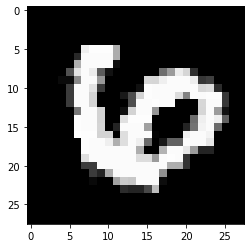

In [ ]:
image,label = trainset[9000]
plt.imshow(image.squeeze(),cmap='gray')

In [ ]:
print("Number of images in Train Set : ", len(trainset))

Number of images in Train Set :  60000


In [ ]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [ ]:
trainloader = DataLoader(trainset,batch_size=batch_size,shuffle=True)

In [ ]:
print("Number of batches in trainloader : ", len(trainloader))

Number of batches in trainloader :  469


In [ ]:
dataiter = iter(trainloader)
images, _ = dataiter.next()
print(images.shape)


torch.Size([128, 1, 28, 28])


In [ ]:
def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
  unflat_img = tensor_img.detach().cpu()
  img_grid = make_grid(unflat_img[:num_images], nrow=4)
  plt.imshow(img_grid.permute(1, 2, 0).squeeze())
  plt.show()


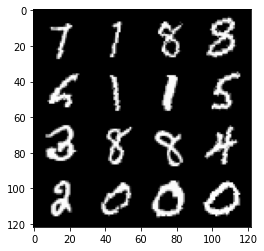

In [ ]:
show_tensor_images(images,num_images=16)

# **MODEL BUILDING**

In [ ]:
from torch import nn
from torchsummary import summary

In [ ]:
def get_disc_block(in_channels, out_channels, kernel_size, stride):
  return nn.Sequential(
  nn.Conv2d(in_channels, out_channels, kernel_size, stride),
  nn.BatchNorm2d(out_channels),
  nn.LeakyReLU(0.2)
)


In [ ]:
class Discriminator(nn.Module):
  def __init__(self):

    super(Discriminator, self).__init__()
    self.block_1 = get_disc_block(1, 16, (3,3), 2)
    self.block_2 = get_disc_block(16, 32, (5,5), 2)
    self.block_3 = get_disc_block(32, 64, (5,5), 2)

    self.flatten = nn.Flatten() 
    self.linear = nn.Linear(in_features = 64, out_features= 1)
  
  def forward(self,images):
    x1 = self.block_1(images)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.flatten(x3)
    x5 = self.linear(x4)
    return x5



In [ ]:
D = Discriminator() 
D.to(device)
summary(D, input_size =(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [ ]:
def get_gen_block(in_channels, out_channels, kernel_size, stride,final_block=False):
  if final_block==True:
    return nn.Sequential(
  nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
  nn.Tanh())

  return nn.Sequential(
  nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
  nn.BatchNorm2d(out_channels),
  nn.LeakyReLU()
)


In [ ]:
class Generator(nn.Module):
  def __init__(self,noise_dim):

    super(Generator, self).__init__()
    self.noise_dim=noise_dim
    self.block_1 = get_gen_block(noise_dim,256,(3,3),2)
    self.block_2 = get_gen_block(256,128,(4,4),1)
    self.block_3 = get_gen_block(128, 64, (3,3), 2)
    self.block_4 = get_gen_block(64,1, (4,4), 2,final_block=True)
  
  def forward(self,r_noise_vec):
    x=r_noise_vec.view(-1,self.noise_dim,1,1)

    x1 = self.block_1(x)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.block_4(x3)
    
    return x4



In [ ]:
G = Generator(noise_dim) 
G.to(device)
summary(G, input_size =(1,noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
         LeakyReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
         LeakyReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
         LeakyReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

# **LOSS CALCULATION**

In [ ]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss


In [ ]:
D_opt = torch.optim.Adam(D.parameters(), lr = lr, betas = (beta_1, beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr = lr, betas = (beta_1, beta_2))


# **PREDICTIONS**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 1 | D loss : 0.6680833910828206 | G loss : 0.7551963714394234


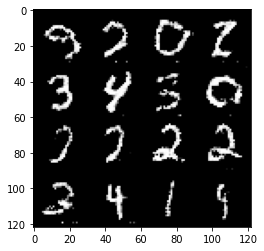

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 2 | D loss : 0.6666563337545659 | G loss : 0.7566120694441073


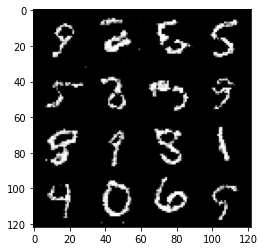

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 3 | D loss : 0.6670714057584816 | G loss : 0.7596871385187991


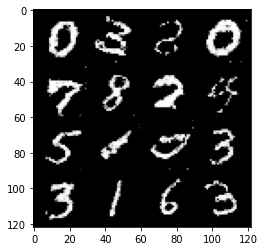

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 4 | D loss : 0.6670995993909042 | G loss : 0.7576188682747294


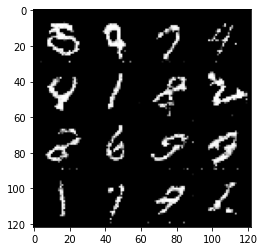

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 5 | D loss : 0.6678266677775109 | G loss : 0.7597403124705561


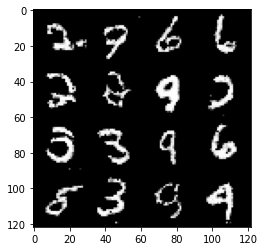

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 6 | D loss : 0.6670549571641219 | G loss : 0.7599733962433171


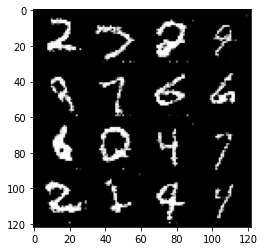

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 7 | D loss : 0.667484303654384 | G loss : 0.759987409689279


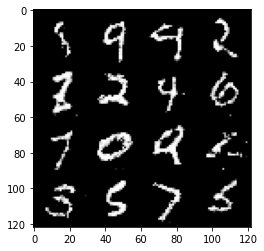

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 8 | D loss : 0.6679291938667866 | G loss : 0.7576526543224799


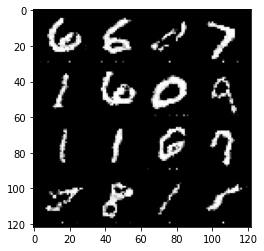

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 9 | D loss : 0.6680425838875109 | G loss : 0.7582721298437383


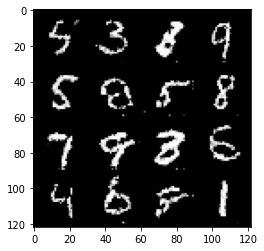

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 10 | D loss : 0.6673460808644163 | G loss : 0.7591861957934365


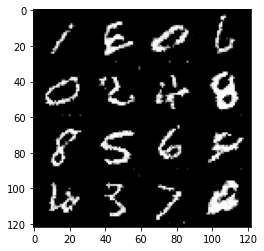

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 11 | D loss : 0.6659651066956997 | G loss : 0.761638712527147


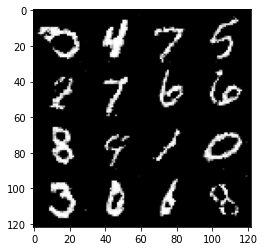

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 12 | D loss : 0.667656652073362 | G loss : 0.7622512584047785


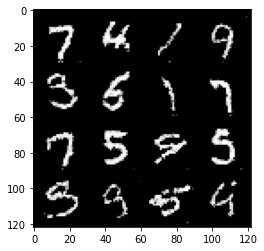

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 13 | D loss : 0.6678612411403453 | G loss : 0.759970128154958


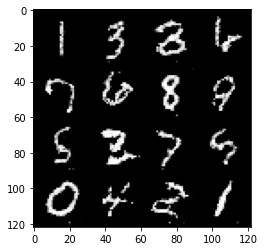

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 14 | D loss : 0.6682345107165989 | G loss : 0.760112626084895


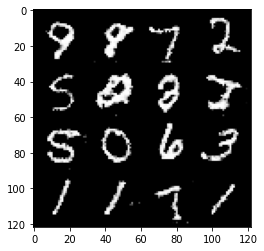

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 15 | D loss : 0.6682280192751366 | G loss : 0.7602869736106157


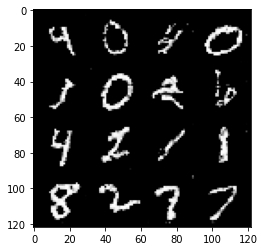

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 16 | D loss : 0.6666818425091091 | G loss : 0.76180640466686


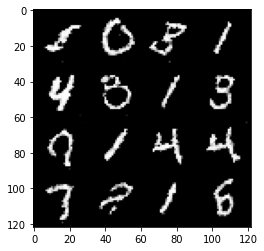

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 17 | D loss : 0.6680564887996422 | G loss : 0.7601794583965212


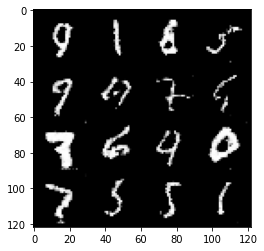

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 18 | D loss : 0.6682619228800223 | G loss : 0.7610947288938169


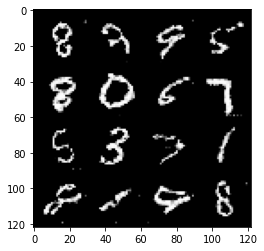

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 19 | D loss : 0.6688888330957783 | G loss : 0.7609953882851834


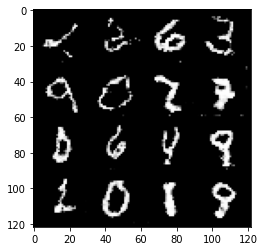

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 20 | D loss : 0.6683780628480891 | G loss : 0.7585676750902937


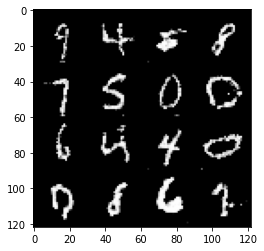

In [ ]:
for i in range(epochs):
  total_d_loss = 0.0
  total_g_loss = 0.0

  for real_img, _ in trainloader:
    real_img = real_img.to(device)
    noise = torch.randn(batch_size, noise_dim, device = device)
    #find loss and update weights for D
    D_opt.zero_grad()
    fake_img = G(noise)
    D_pred = D(fake_img)
    D_fake_loss = fake_loss(D_pred)

    D_pred = D(real_img) 
    D_real_loss = real_loss(D_pred)
    D_loss = (D_fake_loss + D_real_loss)/2
    total_d_loss += D_loss.item()

    D_loss.backward()
    D_opt.step()
    G_opt.zero_grad()
    noise = torch.randn(batch_size, noise_dim, device= device)

    fake_img = G(noise)
    D_pred = D(fake_img)
    G_loss = real_loss(D_pred)
    total_g_loss += G_loss.item()
    G_loss.backward()
    G_opt.step()
  avg_d_loss = total_d_loss / len(trainloader)
  avg_g_loss = total_g_loss / len(trainloader)

  print("Epoch : {} | D loss : {} | G loss : {}".format(i+1, avg_d_loss, avg_g_loss))
  show_tensor_images(fake_img)


